In [1]:
import pandas as pd
import sys

from transformers import AutoTokenizer
from datasets import load_dataset

sys.path.append('../')

from src.preprocessing import DataPreprocessor, FEATURES, PAD_FEATURE_VEC, BOUNDARY_FEATURE_VEC, UNK_FEATURE_VEC, create_phoneme_map
from src.config import DataPreprocessingParams, DatasetParams

In [2]:
phoible = pd.read_csv('../data/phoible.csv', sep=',', encoding='utf-8')

/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_24425/1109117776.py:1: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv('../data/phoible.csv', sep=',', encoding='utf-8')


In [3]:
def compare_phonemes(p1, p2):
    """
    Compare two phonemes and return a list of features that are different.
    """
    p1_features = phoible[phoible['Phoneme'] == p1][FEATURES].values[0]
    p2_features = phoible[phoible['Phoneme'] == p2][FEATURES].values[0]
    return [f for i, f in enumerate(FEATURES) if p1_features[i] != p2_features[i]]

compare_phonemes('ɾ', 'ɻ')

['tap', 'anterior']

In [4]:
tokenizer = AutoTokenizer.from_pretrained('transformersegmentation/CHILDES-Tokenizer')

In [5]:
dataset_params = DatasetParams(subconfig='English', name='transformersegmentation/CHILDES')
data_processing_params = DataPreprocessingParams(max_input_length=64, join_utts=False)

In [6]:
phoneme_map = create_phoneme_map(tokenizer, dataset_params.subconfig, '../data/phoible.csv')

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/CharTransformers/TransformerSegmentation/notebooks/../src/preprocessing.py:29: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  phoible = pd.read_csv(phoible_data_path)


In [7]:

dataset = load_dataset(dataset_params.name, dataset_params.subconfig, split='train')
data_preprocessor = DataPreprocessor(data_processing_params, tokenizer)
dataset = dataset.map(data_preprocessor, batched=True, remove_columns=['text'])
dataset

Found cached dataset childes (/Users/zebulongoriely/.cache/huggingface/datasets/transformersegmentation___childes/English/1.0.0/095e19727e2d33f7808ec4d5c95d086a19ab190ee0ae9ded0d0f7532fa5652c8)
Loading cached processed dataset at /Users/zebulongoriely/.cache/huggingface/datasets/transformersegmentation___childes/English/1.0.0/095e19727e2d33f7808ec4d5c95d086a19ab190ee0ae9ded0d0f7532fa5652c8/cache-e5ff78bc2ceb3cef.arrow


Dataset({
    features: ['input_ids', 'attention_mask', 'word_starts'],
    num_rows: 350664
})

In [8]:
num_phonemes = 0
num_converted_phonemes = 0
phoneme_count = {}
for i in range(dataset.num_rows):
    utt = dataset[i]['input_ids']
    for j, phoneme in enumerate(utt):
        if phoneme < 6:
            continue
        num_phonemes += 1
        if phoneme not in phoneme_count:
            phoneme_count[phoneme] = 1
        else:
            phoneme_count[phoneme] += 1
        if phoneme_map[phoneme][-1] != 2:
            num_converted_phonemes += 1

print(f'Number of phonemes: {num_phonemes}')
print(f'Number of converted phonemes: {num_converted_phonemes}')
print(f'Percentage of converted phonemes: {num_converted_phonemes / num_phonemes * 100}%')

Number of phonemes: 3971851
Number of converted phonemes: 3971851
Percentage of converted phonemes: 100.0%


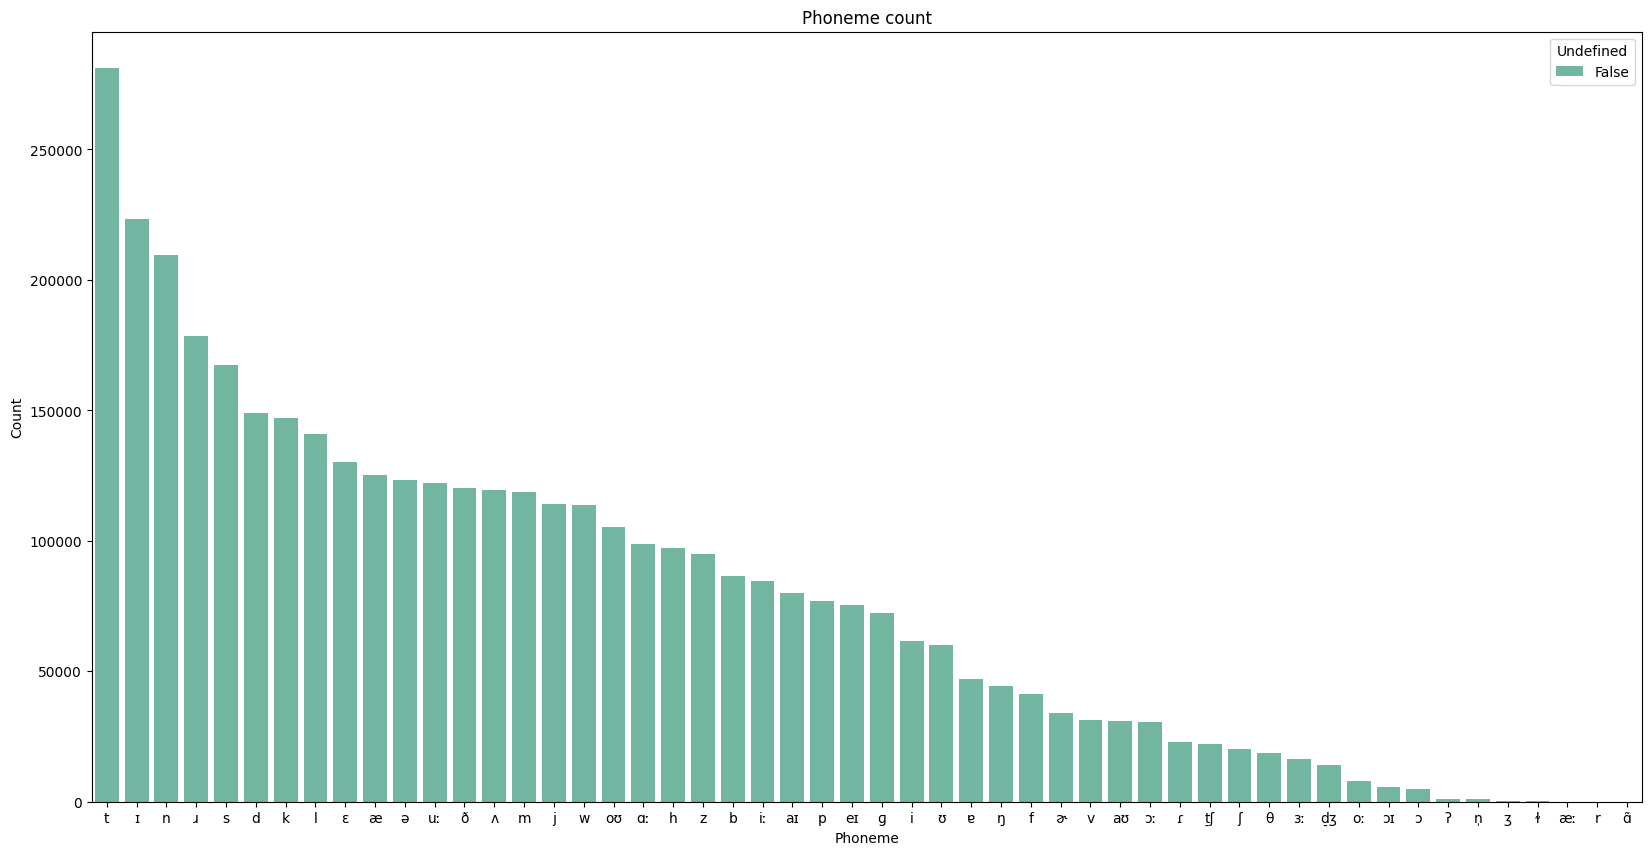

In [9]:
import matplotlib.pyplot as plt
import seaborn

plt.figure(figsize=(20, 10))
plt_data = pd.DataFrame(phoneme_count.items(), columns=['ID', 'Count'])
plt_data['Phoneme'] = plt_data['ID'].map(tokenizer.decode)
plt_data['Undefined'] = plt_data['ID'].map(lambda x: phoneme_map[x] in [PAD_FEATURE_VEC, BOUNDARY_FEATURE_VEC, UNK_FEATURE_VEC])
plt_data = plt_data.sort_values(by='Count', ascending=False)
seaborn.barplot(x='Phoneme', y='Count', data=plt_data, hue='Undefined', dodge=False, palette='Set2')

plt.xlabel('Phoneme')
plt.ylabel('Count')
plt.title('Phoneme count')

plt.show()


Text(0.5, 1.0, 'Feature vectors')

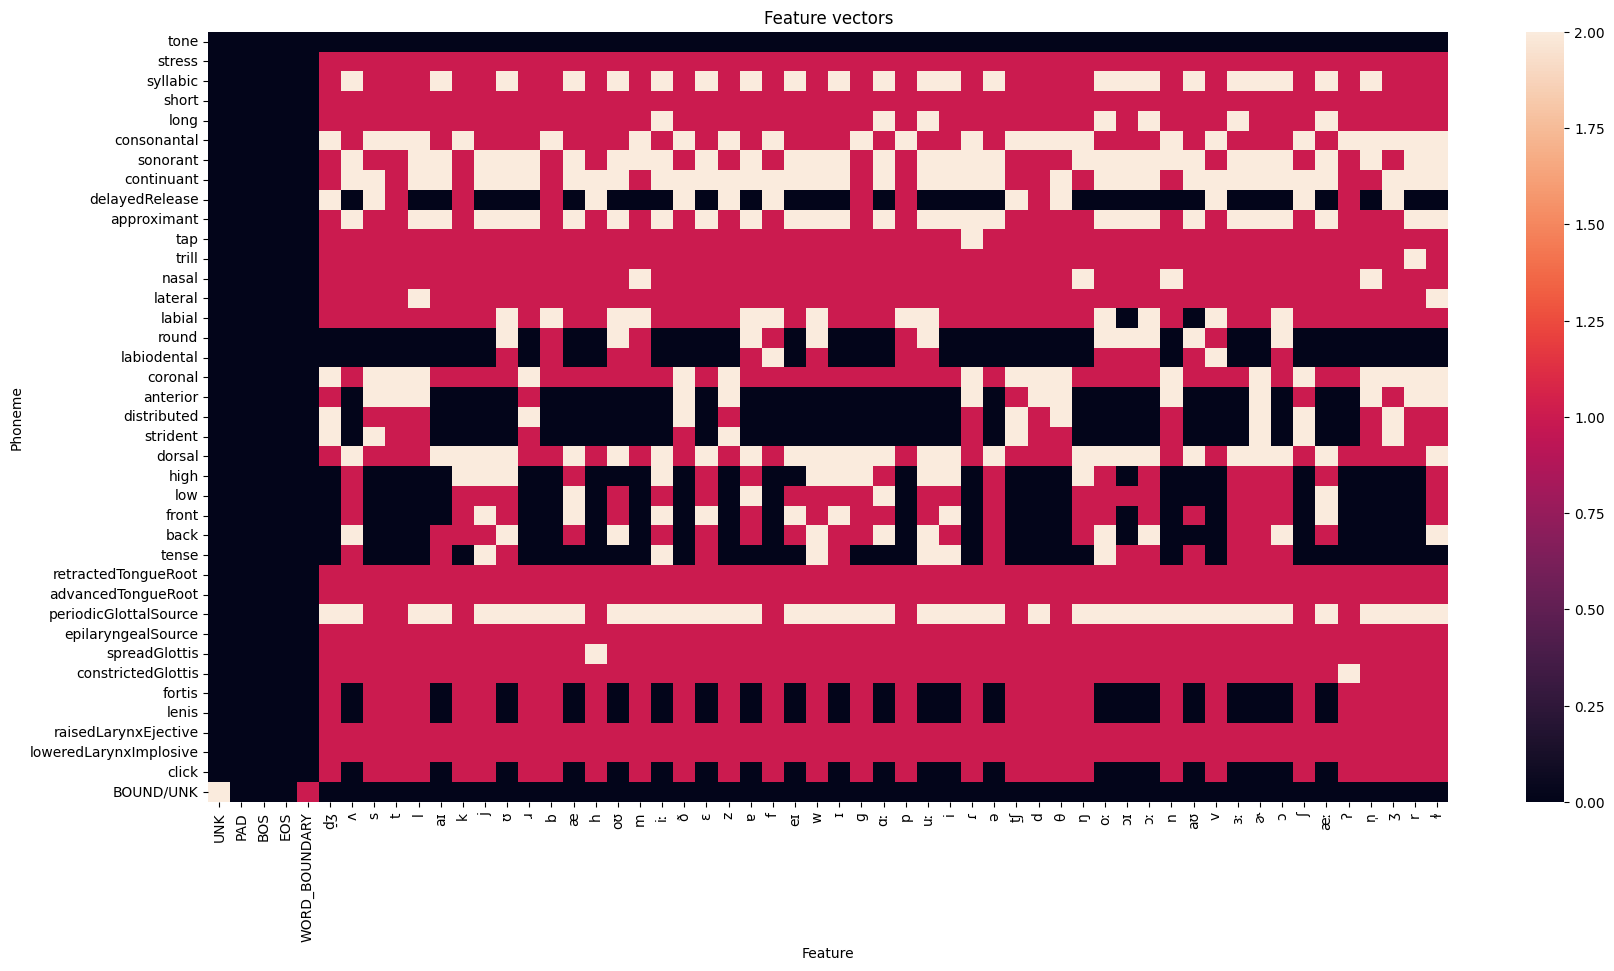

In [10]:
# Visualise feature vectors
import numpy as np
phoneme_ids = tokenizer.vocab.values()
phoneme_features = [phoneme_map[id] for id in phoneme_ids]
counts = [phoneme_count[id] if id in phoneme_count else 0 for id in phoneme_ids]
plt_data = pd.DataFrame({'ID' : phoneme_ids, 'Features' : phoneme_features, 'Phoneme' : tokenizer.vocab.keys(), 'Count' : counts})
plt_data = plt_data.sort_values(by='ID')

# Remove phonemes that have a count of less than 10
plt_data = plt_data[(plt_data['ID'] < 5) | (plt_data['Count'] > 10)]
plt_data = plt_data.set_index('ID')

# Set features to individual columns
for i in range(len(FEATURES)):
    plt_data[FEATURES[i]] = plt_data['Features'].map(lambda x: x[i])
plt_data['BOUNDARY/PAD'] = plt_data['Features'].map(lambda x: x[-1])

# Plot heatmap of feature vectors
plt.figure(figsize=(20, 10))
# seaborn.heatmap(plt_data, cmap='binary', cbar=False, xticklabels=FEATURES + ['BOUND/UNK'], yticklabels=list(plt_data['Phoneme']))
seaborn.heatmap(plt_data.drop(columns=['Features', 'Phoneme', 'Count']).T, yticklabels=FEATURES + ['BOUND/UNK'], xticklabels=plt_data['Phoneme'])
plt.xlabel('Feature')
plt.ylabel('Phoneme')
plt.title('Feature vectors')



In [11]:
american_phonemes = phoible[phoible['LanguageName'] == 'American English'].Phoneme.unique()
british_phonemes = phoible[phoible['LanguageName'] == 'English'].Phoneme.unique()

print (len(american_phonemes), len(british_phonemes))
    

39 64


In [12]:
import numpy as np
phonemes = phoible[phoible['LanguageName'] == 'English'].Phoneme.unique()
allophones = phoible[(phoible['LanguageName'] == 'English') & (phoible['Allophones'].notnull())]['Allophones'].unique()
allophones = [a for b in allophones for a in b.split(' ')]
phonemes = np.unique(np.concatenate((phonemes, allophones)))
phonemes

array(['a', 'aɪ', 'aʊ', 'aː', 'a̟', 'b', 'b̚', 'bⁿ', 'd', 'dz', 'dˡ',
       'd̚', 'd̠ʒ', 'd̪', 'dⁿ', 'e', 'eə', 'eɪ', 'eː', 'e̞', 'f', 'f͉',
       'h', 'i', 'iɛ', 'iː', 'j', 'j̥', 'k', 'kʰ', 'k̚', 'k͉', 'kⁿ', 'l',
       'lˠ', 'l̥', 'l̩ˠ', 'l̪ˠ', 'm', 'm̩', 'n', 'n̩', 'n̪', 'o̞', 'o̞ː',
       'p', 'pʰ', 'p̚', 'p͉', 'pⁿ', 'r', 's', 's͉', 't', 'ts', 'tʰ', 'tˡ',
       't̚', 't̠ʃ', 't̠ʃ͉', 't̪', 't͉', 'tⁿ', 'u', 'uː', 'v', 'w', 'x',
       'z', 'æ', 'æː', 'ç', 'ð', 'ð̞', 'ŋ', 'ŋ̩', 'ɐ', 'ɑː', 'ɒ', 'ɔ',
       'ɔɪ', 'ɔː', 'ɖ', 'ə', 'əʊ', 'əː', 'ɛ', 'ɛʉ', 'ɜ', 'ɜː', 'ɡ', 'ɡ̚',
       'ɡⁿ', 'ɦ', 'ɪ', 'ɪi', 'ɪə', 'ɭ', 'ɱ', 'ɳ', 'ɹ', 'ɻ', 'ɻ̥', 'ɾ',
       'ʃ', 'ʃ͉', 'ʈ', 'ʉː', 'ʊ', 'ʊu', 'ʊə', 'ʋ', 'ʌ', 'ʍ', 'ʐ͇', 'ʒ',
       'ʔ', 'ˀk', 'ˀp', 'ˀt', 'ˀt̠ʃ', 'θ', 'θ͉'], dtype=object)

In [13]:
# Get phonemes undefined in phoneme map
undefined_phonemes = []
for phoneme, count in phoneme_count.items():
    if phoneme_map[phoneme] is UNK_FEATURE_VEC:
        undefined_phonemes.append(tokenizer.convert_ids_to_tokens(phoneme))
undefined_phonemes

[]

In [14]:
phoible[phoible['stress'] == '-']

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass,...,advancedTongueRoot,periodicGlottalSource,epilaryngealSource,spreadGlottis,constrictedGlottis,fortis,lenis,raisedLarynxEjective,loweredLarynxImplosive,click
0,1,kore1280,kor,Korean,NaN,0068,h,ç h ɦ,NaN,consonant,...,-,-,-,+,-,-,-,-,-,-
1,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant,...,-,+,-,-,-,-,-,-,-,-
2,1,kore1280,kor,Korean,NaN,006B,k,k̚ ɡ k,NaN,consonant,...,-,-,-,-,-,-,-,-,-,-
3,1,kore1280,kor,Korean,NaN,006B+02B0,kʰ,kʰ,NaN,consonant,...,-,-,-,+,-,-,-,-,-,-
4,1,kore1280,kor,Korean,NaN,006B+02C0,kˀ,kˀ,NaN,consonant,...,-,-,-,-,+,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105479,3020,lamu1254,lby,Tableland Lamalama,NaN,0294,ʔ,NaN,False,consonant,...,-,-,-,-,+,-,-,-,-,-
105480,3020,lamu1254,lby,Tableland Lamalama,NaN,03B8,θ,NaN,False,consonant,...,-,-,-,-,-,-,-,-,-,-
105481,3020,lamu1254,lby,Tableland Lamalama,NaN,0061,a,NaN,False,vowel,...,-,+,-,-,-,0,0,-,-,0
105482,3020,lamu1254,lby,Tableland Lamalama,NaN,0069,i,NaN,False,vowel,...,-,+,-,-,-,0,0,-,-,0


# GPT2 Feature Model

In [15]:
from transformers import GPT2Config

from src.models.gpt2 import GPT2FeatureModel, GPT2LMHeadModel

In [16]:
config = GPT2Config(vocab_size=tokenizer.vocab_size, n_layer=2, n_head=4, n_embd=64, n_positions=128, n_inner=128)
model = GPT2FeatureModel(config, feature_map=phoneme_map)

In [17]:
model

GPT2FeatureModel(
  (custom_embedding): CustomLinear(in_features=39, out_features=64, bias=True)
  (embedding_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (transformer): GPT2Model(
    (wte): Embedding(85, 64)
    (wpe): Embedding(128, 64)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (lm_heads): ModuleList(
    (0-38): 39 

In [18]:
import torch

input_ids = torch.tensor(dataset['input_ids'][0])
attention_mask = torch.tensor(dataset['attention_mask'][0])
labels = torch.tensor(dataset['input_ids'][0])

In [19]:
model(input_ids=input_ids, attention_mask=attention_mask, labels=labels).logits.shape

torch.Size([1, 39, 64, 3])

In [20]:
model.return_token_logits = True
model.generate(input_ids=input_ids[:5].unsqueeze(0), attention_mask=attention_mask[:5].unsqueeze(0), max_length=64, num_beams=1, do_sample=False)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[ 6,  7,  8,  9, 10, 39, 39, 39, 39,  9, 44, 44, 44, 39, 39, 39, 39, 39,
         44, 44, 39, 39, 39, 44, 39, 39, 39,  9, 39,  7, 39, 39, 44, 44, 39, 44,
         44, 39, 39, 39,  9, 39, 39, 39, 44, 44, 39, 44, 44, 39,  9, 39,  9, 39,
          9, 39, 39, 39, 39, 39, 39, 39, 44, 39]])

In [21]:
from src.segmentation.segment import GPT2FeaturesSegmenter

dataset2 = load_dataset(dataset_params.name, dataset_params.subconfig, split='validation')
segment_eval_sentences = dataset2.select(range(100))["text"]
model.return_token_logits = True
segmenter = GPT2FeaturesSegmenter(model, tokenizer, segment_eval_sentences)

Found cached dataset childes (/Users/zebulongoriely/.cache/huggingface/datasets/transformersegmentation___childes/English/1.0.0/095e19727e2d33f7808ec4d5c95d086a19ab190ee0ae9ded0d0f7532fa5652c8)
